In [99]:
import warnings
warnings.filterwarnings("ignore")

from collections import Counter, ChainMap
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import utilities.helpers as hp

import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Unknown Homeland cases EDA:

# Import data set:


Below we see the shape of the whole dataset.


In [100]:
pd.options.mode.chained_assignment = None

df_full = hp.import_dataset(encoding='utf-8')
# Convert json to csv:
# df_full.to_csv('../data/dk_asylum_data_1.csv', encoding='utf-8', index=False)
df_full.shape


(9635, 5)

# Dataset preprocessing:

Cases of Unknown Homeland (Ukendt hjemland) are kept.

Below we see the shape and head of the dataset.


In [101]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

df = df_UH

df["text"] = df["text"].astype("string")

df.shape

(192, 4)

In [102]:
df.head()

,id,asylum_motive,country,text
287,287,[Etniske forhold],Ukendt hjemland,Nævnet stadfæstede i november 2021 Udl...
515,515,"[Kriminelle forhold, Militære forhold]",Ukendt hjemland,Nævnet stadfæstede i juni 2021 Udlændi...
551,551,"[Sur Place, LGBT, Politiske forhold, Etnisk...",Ukendt hjemland,Nævnet stadfæstede i juni 2021 Udlændi...
989,989,"[Agents of Persecution, Anden kønsrelateret f...",Ukendt hjemland,Nævnet stadfæstede i december 2020 Udl...
1379,1379,"[Militære forhold, Nationalitet]",Ukendt hjemland,Nævnet hjemviste i juni 2020 Udlænding...


Check for potential duplicates and drop them:


In [103]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df


,id,asylum_motive,country,text
1421,1421,"[Inddragelse/forlængelse, Religiøse forhold, ...",Ukendt hjemland,Nævnet stadfæstede i maj 2020 Udlændin...
1440,1440,"[Inddragelse/forlængelse, Religiøse forhold, ...",Ukendt hjemland,Nævnet stadfæstede i maj 2020 Udlændin...
4102,4102,"[Politiske forhold, Generelle forhold]",Ukendt hjemland,Nævnet stadfæstede i januar 2018 Udlæn...
4103,4103,"[Privatretlig forhold, Generelle forhold]",Ukendt hjemland,Nævnet stadfæstede i januar 2018 Udlæn...
4157,4157,"[Nationalitet, Generelle forhold, Udrejsefor...",Ukendt hjemland,Nævnet stadfæstede i januar 2018 Udlæn...
4160,4160,[Emneord:],Ukendt hjemland,Nævnet stadfæstede i januar 2018 Udlæn...


In [104]:
# Drop duplicates from original dataframe based on text column
# If the summary is the same probalbly were are looking at a duplicate
# without taking into account all other variables(columns):
df = df.drop_duplicates('text', keep='last')

# Check shape again:
df.shape


(189, 4)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts.


In [105]:
df['length'] = df['text'].str.len()

df.describe().T


,count,mean,std,min,25%,50%,75%,max
id,189.0,3296.661376,1225.330399,287.0,2632.0,3128.0,3933.0,7295.0
length,189.0,5008.539683,2046.292952,1104.0,3532.0,4753.0,6057.0,13105.0


## Boxplot:


<AxesSubplot:>

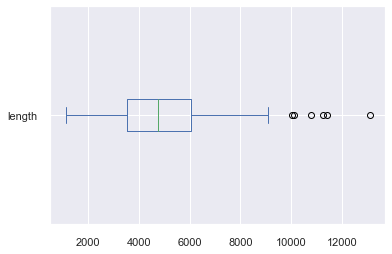

In [106]:
# Box plot:
df['length'].plot(kind='box', vert=False)


# Create a pipeline:


The pipeline consists of the following steps:

- Lowercase all characters
- Drop numbers
- Remove punctuation
- Remove stopwords. The list of stopwords can be found [here](https://github.com/jethronap/AsylumData_KU/blob/main/misc/stopwords_dk.txt).
- Single letter words are dropped, too.
- Tokenization
- Lemmatization. The process during which all words are turned into its roots.

Steps can be added or removed from the pipeline.


In [107]:
pipeline = [str.lower, hp.remove_punctuation, hp.remove_stopwords, hp.drop_single_letter_words,
            hp.tokenize, hp.lemmatize]

In [108]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(hp.process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)


In [109]:
df.head()


,id,asylum_motive,country,text,length,tokens,num_tokens
287,287,[Etniske forhold],Ukendt hjemland,Nævnet stadfæstede i november 2021 Udl...,4753,"[stadfæste, 2021, udlændingestyrels, afgørelse...",325
515,515,"[Kriminelle forhold, Militære forhold]",Ukendt hjemland,Nævnet stadfæstede i juni 2021 Udlændi...,3149,"[stadfæste, 2021, udlændingestyrels, afgørelse...",219
551,551,"[Sur Place, LGBT, Politiske forhold, Etnisk...",Ukendt hjemland,Nævnet stadfæstede i juni 2021 Udlændi...,4433,"[stadfæste, 2021, udlændingestyrels, afgørelse...",318
989,989,"[Agents of Persecution, Anden kønsrelateret f...",Ukendt hjemland,Nævnet stadfæstede i december 2020 Udl...,2664,"[stadfæste, 2020, udlændingestyrels, afgørelse...",184
1379,1379,"[Militære forhold, Nationalitet]",Ukendt hjemland,Nævnet hjemviste i juni 2020 Udlænding...,4626,"[hjemvise, 2020, udlændingestyrels, afgørelse,...",324


# Analysis:


## Exploratory descriptive analysis (EDA):


## Decision extraction:


In [110]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]


In [111]:

# df_stad = df['tokens_joined'].str.contains('stadfæste', regex=True)
# df_hem = df['tokens_joined'].str.contains('hjemvise', regex=True)
# df_med = df['tokens_joined'].str.contains('meddele', regex=True)

# # df['decision'] = np.where(df_stad & (df_hem | df_med), "check", np.nan)
# df['decision'] = np.where((df_hem | df_med) & df_stad, "denied", np.where(
#     df_hem | df_med, "overturned", np.where(df_stad, "denied", np.nan)))

# affirmed decision of Immigration Services
df_stad = df['tokens_joined'].str.contains('stadfæst.*?', regex=True)
# overturned decision of Immigration Services
df_hem = df['tokens_joined'].str.contains('hjemvis.*?', regex=True)
# overturned decision of Immigration Services
df_med = df['tokens_joined'].str.contains('meddel.*?', regex=True)
# overturned decision of Immigration Services
df_omg = df['tokens_joined'].str.contains('omgjor.*?|omgør.*?', regex=True)
# overturned decision of Immigration Services
df_ame = df['tokens_joined'].str.contains('ændr.*?', regex=True)
# overturned decision of Immigration Services
df_oph = df['tokens_joined'].str.contains('ophæv.*?', regex=True)

df['decision'] = np.where(df_stad, 'affirmed', np.where(
    df_hem | df_med | df_omg | df_ame | df_oph, 'overturned', np.nan))


Plot decision outcomes:


In [112]:
colors = ['#941f14', '#177487']
gradient_colors = cm.Reds(np.linspace(1, 0, 20))

Text(0, 0.5, 'outcomes')

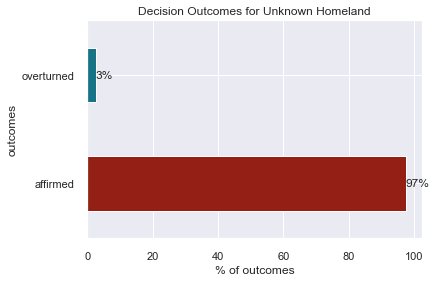

In [113]:

# Plot with normalized values:
ax = df['decision'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
ax.set_xlabel('% of outcomes')
ax.set_ylabel('outcomes')

# Uncomment to plot frequencies:
# ax = df['decision'].value_counts().plot(
#     kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')
# ax.bar_label(container)


## Year extraction:


In [114]:
df['year'] = df['tokens'].str[1]


Plot decision outcomes by year:


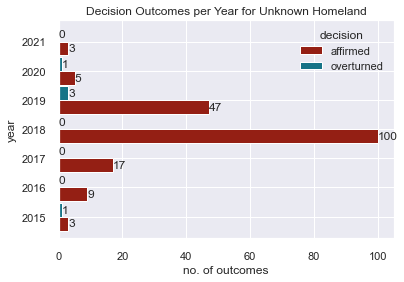

In [115]:
ax = df.groupby(['year'])['decision'].value_counts().unstack().plot(
    kind='barh', title='Decision Outcomes per Year for Unknown Homeland', width=0.95, color=colors)

ax.set_xlabel('no. of outcomes')
ax.set_ylabel('year')

for container in ax.containers:
    ax.bar_label(container)


## Gender of applicants extraction:


In [116]:
male_pat = 'mandl.*?statsborg.*?|mand.*?ansøg.*?|mand.*?klag.*?'
female_pat = 'kvinde.*?statsborg.*?|kvinde.*?ansøg.*?|kvinde.*?klag.*?'

df_female = df['text'].str.contains(female_pat)
df_male = df['text'].str.contains(male_pat)

df['gender'] = np.where(df_male, "male", np.where(
    df_female, "female", "unidentified"))


Plot gender distribution:

NOTE: unidentified means that the regex pattern used does not fully yield the expected results.


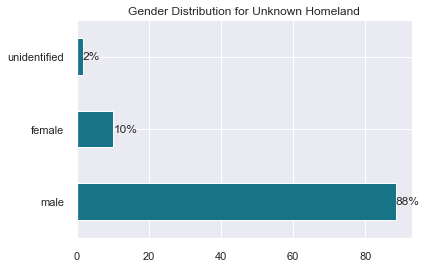

In [117]:
# Plot with normalized values:
ax = df['gender'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color='#177487', title='Gender Distribution for Unknown Homeland')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')


Plot decision outcome rate by gender:


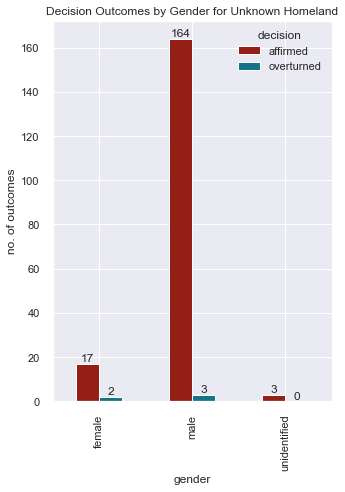

In [118]:
ax = df.groupby(['gender'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes by Gender for Unknown Homeland', color=colors, figsize=(5, 7))
ax.set_xlabel('gender')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)


Plot Decision Outcome Frequencies by Gender for each Year:


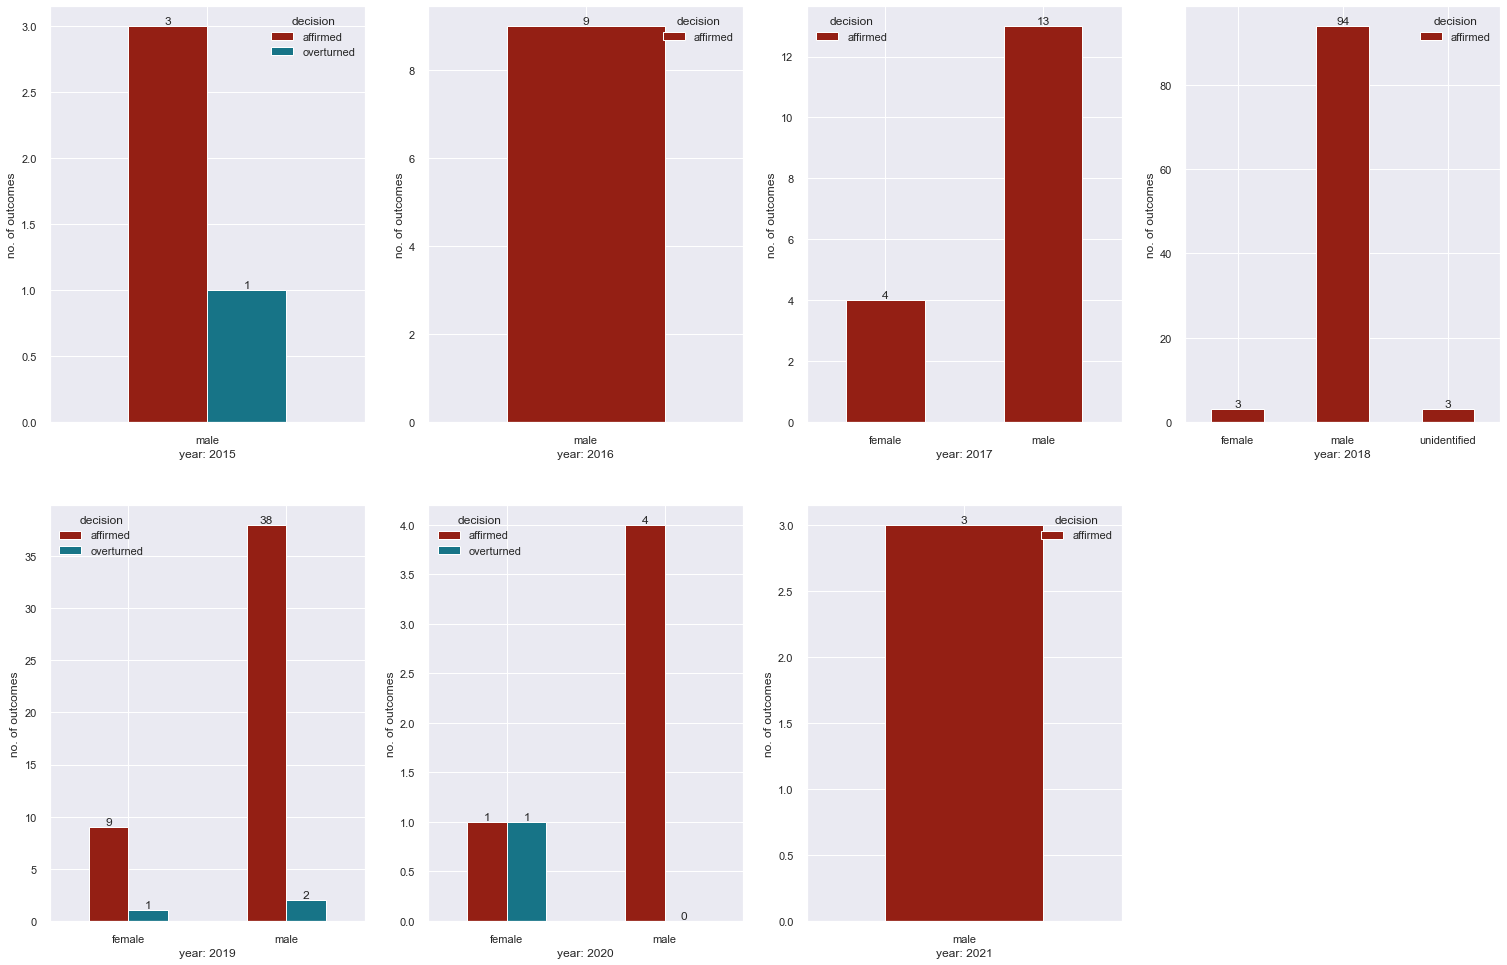

In [119]:
# Uncomment to plot separate figures:
# for year in df['year'].unique():
#     ax = df[df.year==year].groupby(['gender'])['decision'].value_counts().unstack().plot(
#     kind='bar', title='Decision Outcomes by Gender for Unknown Homeland for '+ str(year))
#     ax.set_xlabel('gender')
#     ax.set_ylabel('no. of outcomes')

#     for container in ax.containers:
#         ax.bar_label(container)

# Plot all figures in one:
plt.figure(figsize=(26, 26))
for ix, (key, group) in enumerate(df.groupby('year')):
    ax = plt.subplot(3, 4, ix+1)
    group.groupby('gender')['decision'].value_counts(
    ).unstack().plot(kind='bar', rot=0, ax=ax, color=colors)
    ax.set_xlabel('year: {}'.format(key))
    ax.set_ylabel('no. of outcomes')
    for container in ax.containers:
        ax.bar_label(container)


## Extract Country of Origin:


In [120]:
syria_pat = 'Syr.*?|damask*?'
irak_pat = 'Irak|irak'
kuwait_pat = 'Kuwait'
eritrea_pat = 'eritr.*?'
algeria_pat = 'alger.*?'
iran_pat = 'Iran'
myanmar_pat = 'minbya|myanmar'
sudan_pat = 'sudan'
somalia_pat = 'somalia'
georgien_pat = 'rusland.*?|tjetjen.*?|georg.*?'
gambia_pat = 'gambia'
afghan_pat = 'kabul|afghan.*?'
sahara_pat = '.*?sahara'
libya_pat = 'tripoli|libyen'
liberia_pat = 'Liberia'
palestine_pat = 'palæstinens.*?'
sierra_pat = 'sierra.*?leone'
etiopia_pat = 'etiopien'

df_syria = df['tokens_joined'].str.contains(syria_pat)
df_irak = df['tokens_joined'].str.contains(irak_pat)
df_kuwait = df['tokens_joined'].str.contains(kuwait_pat)
df_eritrea = df['tokens_joined'].str.contains(eritrea_pat)
df_algeria = df['tokens_joined'].str.contains(algeria_pat)
df_iran = df['tokens_joined'].str.contains(iran_pat)
df_myanmar = df['tokens_joined'].str.contains(myanmar_pat)
df_sudan = df['tokens_joined'].str.contains(sudan_pat)
df_somalia = df['tokens_joined'].str.contains(somalia_pat)
df_georgien = df['tokens_joined'].str.contains(georgien_pat)
df_gambia = df['tokens_joined'].str.contains(gambia_pat)
df_afghan = df['tokens_joined'].str.contains(afghan_pat)
df_sahara = df['tokens_joined'].str.contains(sahara_pat)
df_libya = df['tokens_joined'].str.contains(libya_pat)
df_liberia = df['tokens_joined'].str.contains(liberia_pat)
df_palestine = df['tokens_joined'].str.contains(palestine_pat)
df_sierra = df['tokens_joined'].str.contains(sierra_pat)
df_etiopia = df['tokens_joined'].str.contains(etiopia_pat)

df['origin'] = np.where(df_myanmar, 'myanmar', np.where(df_kuwait, 'kuwait',
                np.where(df_iran, 'iran', np.where(df_eritrea, 'eritrea', np.where(df_irak, 'irak',
                np.where(df_libya, 'libya', np.where(df_syria, 'syria', np.where(df_sudan, 'sudan',
                np.where(df_somalia, 'somalia', np.where(df_georgien, 'georgien', np.where(df_gambia, 'gambia',
                np.where(df_afghan, 'afghanistan', np.where(df_sahara, 'sahara', np.where(df_algeria, 'algiers',
                np.where(df_liberia, 'liberia', np.where(df_palestine, 'palestine',
                np.where(df_sierra, 'sierra leone', np.where(df_etiopia, 'etiopia', np.nan))))))))))))))))))


Plot distribution of origin:


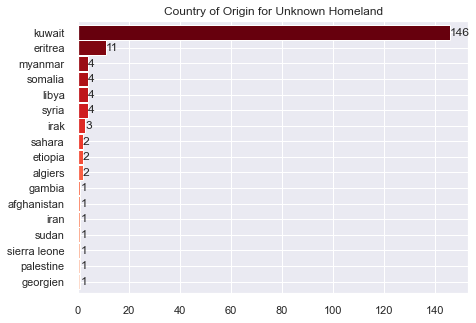

In [121]:
from calendar import c
from turtle import color


ax = df['origin'].value_counts().plot(
    kind='barh', title='Country of Origin for Unknown Homeland', width=0.95,
    color=gradient_colors, figsize=(7,5))
ax.invert_yaxis()
for container in ax.containers:
    ax.bar_label(container)


Plot decision outcome rate by origin:


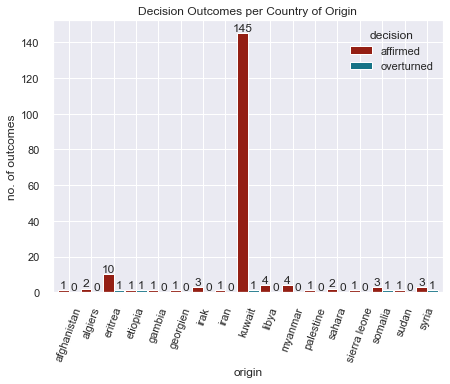

In [122]:
ax = df.groupby(df['origin'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per Country of Origin', 
    figsize=(7, 5), rot=70, width=0.95, color=colors)
ax.set_xlabel('origin')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)


# Asylum motives distribution:

In [123]:
df['asylum_motive'] = df['asylum_motive'].astype("string")

df_motives = df['asylum_motive'].str.split(',').explode().str.strip('[\'\'] ').value_counts()

df_motives


Generelle forhold                  125
Politiske forhold                   89
Nationalitet                        75
Etniske forhold                     53
Sagsoplysning                       16
Privatretlig forhold                14
Beviskrav og bevisvurdering         11
Udrejseforhold                       9
Agents of Persecution                8
Militære forhold                     6
Ægteskabelige forhold                6
Inddragelse/forlængelse              6
Tortur                               6
LGBT                                 4
Seksuelle forhold                    3
Chikane                              3
Kriminelle forhold                   3
Mindreårige                          2
Tilknyt bistand oprørsgruppe         2
Religiøse forhold                    2
Privatretlig konflikt                2
Sur Place                            2
Anden kønsrelateret forfølgelse      1
Overgreb                             1
To-instansbehandling                 1
Emneord:                 

Plot ten most frequent asylum motives:

Text(0, 0.5, 'frequency')

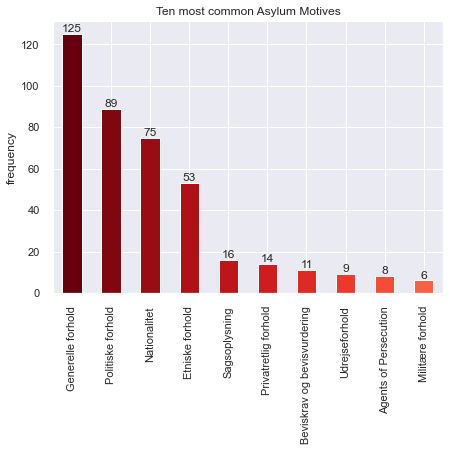

In [124]:
ax = df_motives.iloc[:10].plot(kind='bar', color=gradient_colors,
                               rot=90, title='Ten most common Asylum Motives', figsize=(7, 5))

for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('frequency')


# Set of locations referred in UH appeals:

In [125]:
# Create a DOC object from every row in pandas given column:
docs = list(hp.nlp.pipe(df['text']))

loci = []
for d in docs:
    # see set of locations:
    s=set(hp.get_locations(d))
    loci.append(s)

loci

[{('bangladesh', 'LOC'),
  ('damaskus', 'LOC'),
  ('danmark', 'LOC'),
  ('dhaka', 'LOC'),
  ('europa', 'LOC'),
  ('holland', 'LOC'),
  ('istanbul', 'LOC'),
  ('minbya', 'LOC'),
  ('myanmar', 'LOC'),
  ('rohingyaer', 'LOC'),
  ('singapore', 'LOC'),
  ('syrien', 'LOC')},
 {('algeriet', 'LOC'),
  ('algeriets', 'LOC'),
  ('algier', 'LOC'),
  ('casablanca', 'LOC'),
  ('danmark', 'LOC'),
  ('frankrig', 'LOC'),
  ('marokko', 'LOC'),
  ('sverige', 'LOC')},
 {('australien', 'LOC'),
  ('danmark', 'LOC'),
  ('juba', 'LOC'),
  ('south sudan', 'LOC'),
  ('sprogtests', 'LOC'),
  ('sudan', 'LOC'),
  ('sydsudan', 'LOC')},
 {('danmark', 'LOC'), ('kenya', 'LOC'), ('somalia', 'LOC')},
 {('eritrea', 'LOC'), ('etiopien', 'LOC'), ('sudan', 'LOC')},
 {('danmark', 'LOC'),
  ('europa', 'LOC'),
  ('holland', 'LOC'),
  ('iran', 'LOC'),
  ('kobala', 'LOC')},
 {('danmark', 'LOC'),
  ('eritrea', 'LOC'),
  ('etiopien', 'LOC'),
  ('italien', 'LOC'),
  ('libyen', 'LOC')},
 {('kuwait', 'LOC')},
 {('4.-17', 'LOC'),
  ('

# Distribution of Bidoon cases:

In [126]:
bidoon_pat = 'bidoon.*?'

df_biddons = df['tokens_joined'].str.contains(bidoon_pat)
df['bidoons'] = np.where(df_biddons, 'bidoon', 'other')


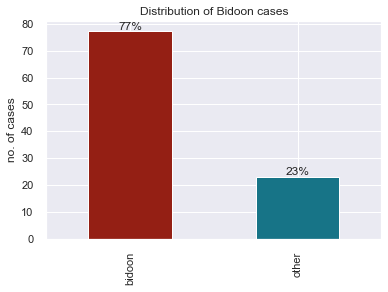

In [127]:
ax = df['bidoons'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='bar', title='Distribution of Bidoon cases', color=colors)
# ax.set_xlabel('bidoon')
ax.set_ylabel('no. of cases')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')

Yearly distribution of Bidoon cases:

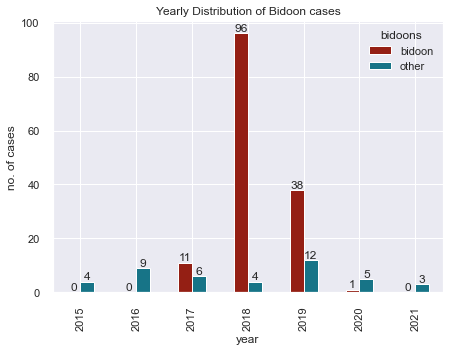

In [128]:
ax = df.groupby('year')['bidoons'].value_counts().unstack().plot(
    kind='bar', title='Yearly Distribution of Bidoon cases', color=colors, figsize=(7,5))
# ax.set_xlabel('bidoon')
ax.set_ylabel('no. of cases')

for container in ax.containers:
    ax.bar_label(container)

Decision outcome rate for Bidoon cases:

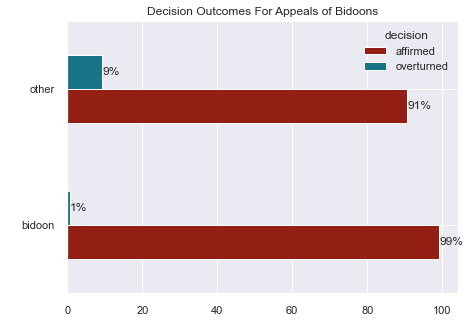

In [129]:
ax = df.groupby('bidoons')['decision'].value_counts(normalize=True).mul(100).round(1).unstack().plot(
    kind='barh', title='Decision Outcomes For Appeals of Bidoons', color=colors, figsize=(7,5))
ax.set_ylabel(' ')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')

## Search for specific keywords (terms):


Look for `last name (efternavn)`. See how many times are they referred to in the texts.


In [130]:
df['last_name'] = df['tokens_joined'].str.extract(
    r'(efternav.?)', hp.re.IGNORECASE)
df['last_name'].value_counts()


efternavn    12
Name: last_name, dtype: int64

In [131]:
# Look up `§7 stk. 2.` occurencies.

# df['law_articles'] = df['text'].str.extract(r'(§ 7.*?stk. 2.*?)')
# df['law_articles'].value_counts()

## Keyword in context (KWIC):

KWIC analysis produces a list of text fragments of equal length showing the left and right context of a keyword.


Check the context around `efternavn`. See all 18 context instances of term.


In [132]:
hp.kwic(df['text'], 'efternavn', print_samples=18) 

18 random samples out of 18 contexts for 'efternavn':
ingsvis til de danske myndigheder oplyst at have efternavnet [C]. Ved fornyet afhøring i Danmark er  efternavn et angivet som [D], hvilket svarer til den mandlige ansøgers efternavn. I henhold til de græske mynd
mark, som han ønskede at bo i nærheden af, og at der er navnesammenfald mellem denne familie og det  efternavn , ansøgeren er registreret med i Grækenland. Der er endvidere sammenfald med familiens nationalitet 
er, at den kvindelige ansøger [F] ved indrejse i Grækenland er registreret som iraker med [et andet  efternavn ], og den kvindelige ansøger [G] ved indrejse i Ungarn er registreret som syrer med [et andet navn].
tivet, jf. nærmere nedenfor – anses for påfaldende, at ansøgeren ved sin ankomst til Danmark brugte  efternavn et [AB], som også er hendes nuværende irakiske ægtefælles efternavn. Sprogtesten kan ikke føre til e
e ansøgers efternavn. I henhold til de græske myndigheders registreringer har hun imidlertid oplys

Check context around `familie`. See ten random samples.

In [133]:
hp.kwic(df['text'], 'familie', print_samples=10)

10 random samples out of 601 contexts for 'familie':
aft en central rolle i planlægningen eller udførelsen af hverken demonstrationen i 2014 eller 2015.  Familie n er kommet med forskellige oplysninger om, hvornår og hvor ofte familien er blevet opsøgt af de kuw
s forklaringer om den mandlige ansøgers konflikt til grund, idet ansøgerne og den mandlige ansøgers  familie  har forklaret divergerende, herunder indbyrdes divergerende, og fordi flere dele af deres forklarin
n ikke vidste, hvorfor hans og familien udrejse af Myanmar, og at han ikke var bekendt med, at hans  familie  havde haft problemer eller konflikter i Myanmar. For Flygtningenævnet har ansøgeren forklaret, at h
 familie udrejste illegalt med fly til Tyrkiet [i sommeren] 2015. Ansøgerens søster, [E], og hendes  familie  udrejste af Kuwait før ansøgerens familie og indrejste i Danmark før dem. Efterfølgende har[A] fået
end 5 år siden. Ansøgeren har forklaret divergerende om, hvornår hans mor tog kontakt til bilistens  famili

Bellow we apply KWIC for `stk` keyword found from the frequency analysis and print 10 random context appearances.

The call is made to the original untokenized & unprocessed dataset.


In [134]:
hp.kwic(df['text'], 'stk', print_samples=10)

10 random samples out of 363 contexts for 'stk':
t ikke er sandsynliggjort, at betingelserne for opholdstilladelse i medfør af udlændingelovens § 7,  stk . 1 og stk. 2, er opfyldt. Flygtningenævnet stadfæster derfor Udlændingestyrelsens afgørelse.”  hjem
sandsynliggjort, at betingelserne for opholdstilladelse i medfør af udlændingelovens § 7, stk. 1 og  stk . 2, er opfyldt. Flygtningenævnet stadfæster derfor Udlændingestyrelsens afgørelse.”  hjem/2019/1/JA
øgeren ikke har sandsynliggjort, at betingelserne for opholdstilladelse efter udlændingelovens § 7,  stk . 1, eller stk. 2, er opfyldt. Flygtningenævnet stadfæster derfor Udlændingestyrelsens afgørelse.” H
andsynliggjort sit asylmotiv. Betingelserne for opholdstilladelse i medfør af udlændingelovens § 7,  stk . 1, eller stk. 2 er derfor ikke opfyldt. Flygtningenævnet stadfæster derfor Udlændingestyrelsens af
jemlandet vil være i risiko for konkret og individuel forfølgelse omfattet af udlændingelovens § 7,  stk . 1. Ansøgeren findes 

KWIC for `opholdstilladelse`.


In [135]:
hp.kwic(df['text'], 'opholdstilladelse', print_samples=10)

10 random samples out of 228 contexts for 'opholdstilladelse':
stride, at hun har været i Holland. Flygtningenævnet finder derfor, at betingelserne for at meddele  opholdstilladelse  efter udlændingelovens § 7, stk. 1 eller stk. 2, ikke er opfyldt. Flygtningenævnet stadfæster derfo
sen. Flygtningenævnet har i en samtidig afgørelse meddelt ansøgerens forældre og søskende afslag på  opholdstilladelse  med følgende begrundelse: ”Flygtningenævnet finder, at i hvert fald dele af ansøgernes forklaringer
forlængelse af klagerens opholdstilladelse, idet Udlændingestyrelsen vurderede, at han havde opnået  opholdstilladelse n ved svig, jf. udlændingelovens § 11, stk. 2, jf. § 19, stk. 2, nr. 1, og § 19 a, stk. 2, jf. § 26,
n ved indrejsen i Danmark afgav bevidst urigtige oplysninger om sin identitet og således har opnået  opholdstilladelse  ved svig. Betingelserne for at inddrage klagerens opholdstilladelse efter udlændingelovens § 19, st
 derfor også enig med Udlændingestyrelsen i, at betingels

KWIC for `§ 7` keyword.


In [136]:
hp.kwic(df['text'], '§ 7', print_samples=10)

10 random samples out of 368 contexts for '§ 7':
ed sin tilbagevenden til Afghanistan vil være i risiko for forfølgelse omfattet af udlændingelovens  § 7 , stk. 1, eller i risiko for overgreb omfattet af § 7, stk. 2. Flygtningenævnet stadfæster derfor Ud
nliggjort, at hun ved en tilbagevenden til sit hjemland risikerer forfølgelse, jf. udlændingelovens  § 7 , stk. 1, eller har behov for beskyttelsesstatus, jf. udlændingelovens § 7, stk. 2. Den foretagne sp
siko for at blive udsat for forfølgelse eller asylbegrundende overgreb omfattet af udlændingelovens  § 7 . Flygtningenævnet stadfæster herefter Udlændingestyrelsens afgørelse.” Med samme begrundelse som i 
r og intensitet, at disse forhold kan anses for omfattet af anvendelsesområdet for udlændingelovens  § 7 , stk. 1 eller stk. 2. Tilsvarende gælder i forhold til den omstændighed, at ansøgerne er udrejst il
Ulovlig udrejse fra hjemlandet kan ikke i sig selv medføre opholdstilladelse efter udlændingelovens  § 7 . Ansøgerne har hereft

# Natural Language Processing:


## Frequency analysis:

Here the most frequent tokens in the **whole** corpus are counted.

The table below presents top ten words.


In [137]:
# See ten most frequent words in the whole corpus:
freq_df = hp.count_words(df)
freq_df.head(10)

# See all words with their frequencies:
# pd.value_counts(np.hstack(df['tokens']))


,freq
token,
ansøger,3630
Kuwait,1370
forklare,1237
oplyse,815
myndighed,796
mandlig,794
asylmotiv,749
forklaring,675
lægge,649


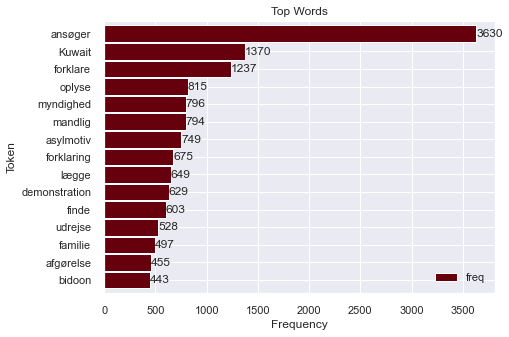

In [138]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95, color=gradient_colors, figsize=(7,5))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

for container in ax.containers:
    ax.bar_label(container)


## N-gram analysis:


In [139]:
values = defaultdict(int)

# Get the count of every bigram in the data set from last processed column:
for text in df['tokens_joined']:
    for word in hp.generate_N_grams(text, 2):
        values[word] += 1


In [140]:
# Focus on more frequently occuring words and sort in descending order with respect to the column of interest:
df_processed = pd.DataFrame(
    sorted(values.items(), key=lambda x: x[1], reverse=True))

# Rename dataframe columns:
df_processed.columns = ['Bigrams', 'Frequency']

Text(0, 0.5, 'Frequencies')

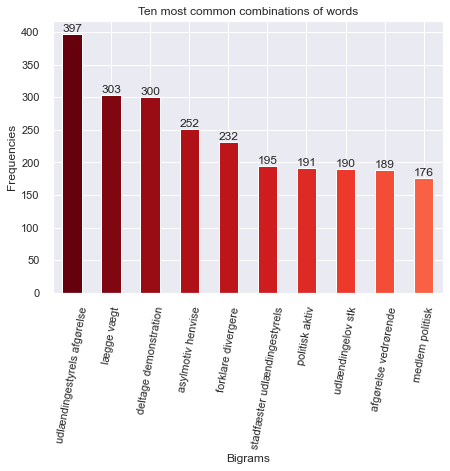

In [141]:
# Plot ten most common combinations of Bigrams:
ax = df_processed.set_index('Bigrams')['Frequency'].iloc[:10].plot(kind='bar', color=gradient_colors,
                               rot=80, title='Ten most common combinations of words', figsize=(7, 5))

for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('Frequencies')

## TF-IDF


Below is the shape of the resulting vector of the vocabulary created from the given context.


In [142]:
# Get the column of interest:
docs = df['tokens_joined'].tolist()

# Create a vocabulary of words:

cv = CountVectorizer()
word_count_vector = cv.fit_transform(docs)

# Get shape of resulting vector:
word_count_vector.shape


(189, 4312)

Ten random words from the vocabulary:


In [143]:
# Look at 10 words from our vocabulary:
list(cv.vocabulary_.keys())[:10]


['stadfæste',
 '2021',
 'udlændingestyrels',
 'afgørelse',
 'vedrørende',
 'mandlig',
 'statsborger',
 'ukendt',
 'hjemland',
 'indrejst']

Peek at the IDF values array:


In [144]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)


# Peek at the IDF values:
tfidf_transformer.idf_


array([5.55387689, 5.55387689, 3.11152986, ..., 4.63758616, 5.55387689,
       3.35665231])

In [145]:
# We only need to do this once:
feature_names = cv.get_feature_names_out()

# Generate tf-idf for all documents in list. docs has 189 documents:
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs))

results = []
for i in range(tf_idf_vector.shape[0]):

    # get vector for a single document
    curr_vector = tf_idf_vector[i]

    # sort the tf-idf vector by descending order of scores
    # tocoo() Return a COOrdinate representation of this matrix.
    sorted_items = hp.sort_coo(curr_vector.tocoo())

    # extract only the top n; n here is 10
    keywords = hp.extract_top_n_from_vector(feature_names, sorted_items, 10)

    results.append(keywords)

df_tfIDF = pd.DataFrame(zip(docs, results), columns=['doc', 'keywords'])
# df_tfIDF.shape
df_tfIDF

,doc,keywords
0,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'myanmar': 0.398, 'rohingya': 0.298, 'ansøger..."
1,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'algerium': 0.398, 'ansøger': 0.36, 'frankrig..."
2,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'ansøger': 0.323, 'sudan': 0.291, '2020': 0.2..."
3,stadfæste 2020 udlændingestyrels afgørelse ved...,"{'somalia': 0.435, 'alshabaab': 0.419, 'kenya'..."
4,hjemvise 2020 udlændingestyrels afgørelse vedr...,"{'eritreisk': 0.402, 'eritrea': 0.352, 'etiopi..."
...,...,...
184,stadfæste 2016 udlændingestyrels afgørelse ved...,"{'fader': 0.475, 'liyu': 0.351, 'police': 0.30..."
185,stadfæste 2015 udlændingestyrels afgørelse ved...,"{'onlf': 0.436, 'police': 0.311, 'liyu': 0.311..."
186,hjemvise 2015 udlændingestyrels afgørelse vedr...,"{'etiopien': 0.197, 'hjemvise': 0.188, 'foreta..."
187,stadfæste 2015 udlændingestyrels afgørelse ved...,"{'soldat': 0.536, 'burmesisk': 0.216, 'burma':..."


Twenty most common words based on TF-IDF values


In [146]:
# Create a dictionary from results list of dictionaries:
my_dict = dict(ChainMap(*results))

c = Counter(my_dict)

# Returns top 20 most common pairs:
most_common = c.most_common(20)

# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

# Add pretty printer:
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(most_common)


[   ('klager', 0.81),
    ('officer', 0.644),
    ('taliban', 0.575),
    ('soldat', 0.536),
    ('libyen', 0.522),
    ('police', 0.497),
    ('liyu', 0.497),
    ('ægtefælle', 0.496),
    ('senegal', 0.472),
    ('tjetjenie', 0.472),
    ('georgien', 0.472),
    ('sierra', 0.466),
    ('leone', 0.466),
    ('libysk', 0.456),
    ('avis', 0.45),
    ('holland', 0.443),
    ('hær', 0.437),
    ('somalia', 0.435),
    ('ghanesisk', 0.433),
    ('bøde', 0.426)]


Plotting the pairs:


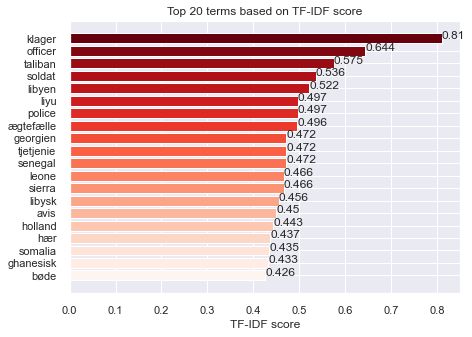

In [148]:
# sort by key and return a tuple:
sorted_most_common = sorted(most_common, key=lambda x: x[1])

# unpack a list of pairs into two tuples:
x, y = zip(*sorted_most_common)

plt.figure(figsize=(7, 5))

plt.barh(x, y, color=gradient_colors[::-1])

for k, v in enumerate(y):
    plt.text(v, k, str(v))

plt.xlabel('TF-IDF score')
# plt.ylabel('Tokens')
plt.title('Top 20 terms based on TF-IDF score')
plt.show()
